#Challenge: Looking for similar patients, the AI Doctor House conquers severe COVID-19!
##Team: FrancoArgentina 
---

The task consists in the development of systems able to detect similarities among a collection of clinical case texts.

The corpus is composed of 2500 clinical cases in Spanish of COVID-19 and non COVID-19 patients. 

Our approach has been to:
1.   obtain a representation of each case in the corpus by training a LSTM autoencoder
2.   find clusters of cases by applying a HDBCcan on t-SNE components computed on the encoder output
3.   check the consistency of our clusters by computing the mean pairwise distance on TF-IDF features across the cluster 
4.   gain further knowledge on the clusters by extracting the dominant topics in each cluster with Latent Dirichlet Allocation


---









##Reading the data

In [439]:
# Importing libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd

In [440]:
# Mounting Google drive where we saved our data and embeddings (not used)
from google.colab import drive
drive.mount('/content/drive')

# Unzip all the cases txt files
# import zipfile
# with zipfile.ZipFile('drive/MyDrive/Hackaton/covid-marato-clinical-cases.zip', 'r') as zip_ref:
#     zip_ref.extractall('drive/MyDrive/Hackaton')

# Read each case txt file
import glob
import re

cases = {}
for doc in glob.glob('drive/MyDrive/Hackaton/covid-marato-clinical-cases/covid_marato*txt'):
    with open(doc, 'r') as reader:
        case_id = int(re.sub('.txt', '', re.sub('.*marato_',  '', doc)))
        cases[case_id] = re.sub('\\n', ' ', reader.read().lower())
        reader.close()
print("\nNumber of cases: ",len(cases))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Number of cases:  2500


Let's have a look at two cases

In [441]:
print("Case 2: ",cases[2])
print("\nCase 2259: ",cases[2259])

Case 2:  mujer de 32 años. refiere estreñimiento ha-bitual, en aumento durante la última temporada. la exploración física resulta anodina salvo el tacto rectal, en el que se palpa a punta de dedo una protrusión redondeada, blanda, y no dolorosa en la cara lateral derecha de la pared rectal. se solicita una ecografía abdominal apreciándose una masa de aspecto quístico y dudosa etiología de localización pararrectal derecha, de unos 34 mm de diámetro longitudinal. se solicita una rm de pelvis menor para filiar la lesión quística hallada en la ecografía, que se informa como una formación redondeada (4,8 x 2,7 cm), bien delimitada, con una cápsula fina y un contenido que muestra una intensidad de señal homogénea (tenuamente hipointenso en t2 y con una mayor señal en stir) en espacio pararrectal derecho y produciendo compresión sobre el mismo, pudiendo tratarse de una anomalía congénita. la paciente es derivada al servicio de cirugía general para tratamiento quirúrgico programado con la sosp

In [442]:
# Convert cases data to dataframe
data = pd.DataFrame.from_dict(cases, orient='index', columns=['case'])
data = data.sort_index(axis=0)
print(data.head(5))

                                                case
1  anamnesis paciente de 31 años, al que, tras un...
2  mujer de 32 años. refiere estreñimiento ha-bit...
3  niño de tres meses que presenta eritema y edem...
4  paciente de 4 años remitido a consulta de ofta...
5  anamnesis mujer sin antecedentes patológicos d...


In [443]:
from sklearn.utils import shuffle

# Shuffle the data
data = shuffle(data)

X_train = data['case'].values

#Check dimenension
print(np.shape(X_train))

(2500,)


##1. LSTM autoencoder

The encoder has 1 LSTM layer followed by a dense layer. The decoder has a bidirectionnal LSTM layer followed by a dense layer. We use Adam optimizer and categorical cross-entropy as loss.

Note: The model archicture lets the user define recurrency with timesteps but we do not make use of this possibility here. As we work with independent documents previous documents do not bear meaningful information for the next one.

In [444]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector, Bidirectional
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives

# Function to define model architecture
def create_lstm_autoencoder(input_dim, timesteps, latent_dim):
    """
    Creates an LSTM Autoencoder. Returns Autoencoder, Encoder. 
    (All code by fchollet - see reference.)
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.(set to 1 here)
        latent_dim: int, latent z-layer shape. 
    # References
        - [Keras implementation of LSTM Autoencoder](https://github.com/twairball/keras_lstm_vae)
    """

    inputs = Input(shape=(timesteps, input_dim,))
    # x_embed = embedding_layer(inputs)
    encoded = LSTM(latent_dim)(inputs)
    encoded = Dense(latent_dim, activation='relu') (encoded)

    decoded = RepeatVector(timesteps)(encoded)
    decoded = Bidirectional(LSTM(input_dim, return_sequences=True),merge_mode='sum')(decoded)
    decoded = Dense(input_dim, activation='relu') (decoded)
  
    sequence_autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss="categorical_crossentropy")
    print(autoencoder.summary())
    return autoencoder, encoder

### Pre-processing

We tokenize our documents with a cutoff at 900 tokens, adding a padding when necessary and reshape our input.

In [445]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

num_words = 2000
maxlen = 900
# embed_dim = 150

tokenizer = Tokenizer(num_words = num_words, split=' ')
tokenizer.fit_on_texts(X_train)
seqs = tokenizer.texts_to_sequences(X_train)
pad_seqs = pad_sequences(seqs, maxlen)
print("oriniginal shape:", pad_seqs.shape)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

timesteps = 1
dataX = []
for i in range(len(x_t)):
    x = pad_seqs[i:(i+timesteps), :]
    dataX.append(x)
x_t_rs = np.array(dataX)
print("reshaped:", x_t_rs.shape)

oriniginal shape: (2500, 900)
Found 36849 unique tokens.
reshaped: (2500, 1, 900)


###Hyperparameters and training:

We set the dimension of the encoder output, the latent space dimension at 64. Batch size at 5 and 30 epochs.

In [446]:
max_len = MAX_SEQUENCE_LENGTH
batch_size = 5
latent_dim = 64

ae, encoder = create_lstm_autoencoder(max_len, 
    timesteps= timesteps, 
    latent_dim= latent_dim)

ae.fit(x_t_rs, x_t_rs,batch_size= batch_size,
          epochs=30)

Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 1, 900)]          0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 64)                247040    
_________________________________________________________________
dense_36 (Dense)             (None, 64)                4160      
_________________________________________________________________
repeat_vector_21 (RepeatVect (None, 1, 64)             0         
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 1, 900)            6948000   
_________________________________________________________________
dense_37 (Dense)             (None, 1, 900)            810900    
Total params: 8,010,100
Trainable params: 8,010,100
Non-trainable params: 0
________________________________________________

##2. Clustering on latent space representation
 We extract the latent space representations of the documents in the corpus (encoder output).

In [447]:
latent_space = encoder.predict(x_t_rs)
latent_space_arr = np.asarray(latent_space)
print("Check dimension;",latent_space_arr.shape)


Check dimension; (2500, 64)


We build a 2 dimensional t-SNE representation of the encoder output using cosine similarity as metric and Barnes-Hut method.


In [448]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, init='random', metric='cosine', random_state=None, method='barnes_hut')
tsne_results = tsne.fit_transform(latent_space_arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.000s...
[t-SNE] Computed neighbors for 2500 samples in 0.156s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.103134
[t-SNE] KL divergence after 1000 iterations: 0.928860


We can visualize the results and see at least 9 potential clusters.

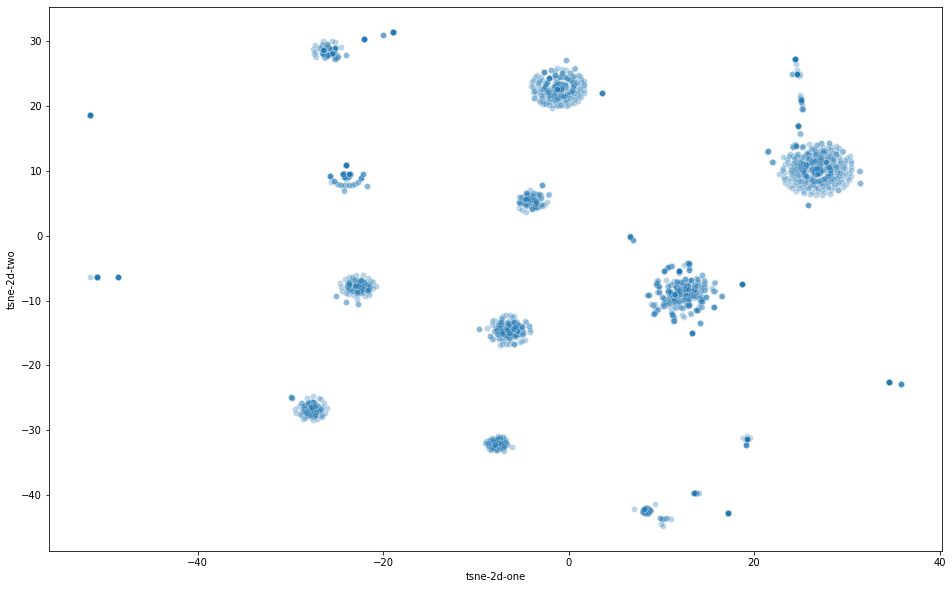

In [449]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame({"tsne-2d-one": tsne_results[:,0], "tsne-2d-two":tsne_results[:,1]})
               
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

We apply HDBScan on top of the t-SNE results with a minimum cluster size of 30 and visualize our clusters.

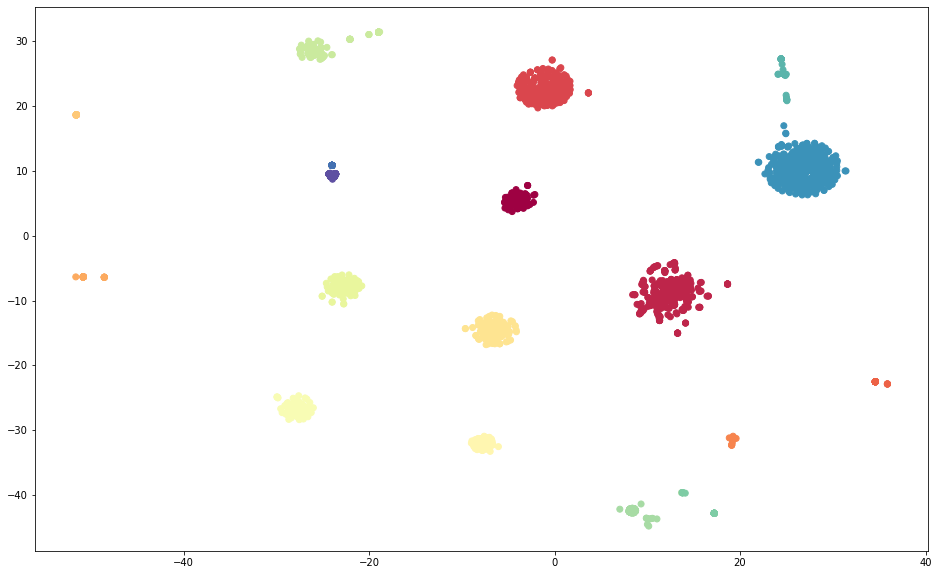

In [450]:
# !pip install hdbscan
import hdbscan

labels = hdbscan.HDBSCAN(
    min_samples=None,
    metric = 'braycurtis',
    min_cluster_size=30,
).fit_predict(tsne_results)

clustered = (labels >= 0)
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[clustered, 0],
            tsne_results[clustered, 1],
            c=labels[clustered],
            cmap='Spectral');

# import umap
# clusterable_embedding = umap.UMAP(
#     # n_neighbors=91,
#     # min_dist=0.0,
#     n_components=2,
#     random_state=42,
#     metric = 'cosine'
# ).fit_transform(latent_space_arr)

# plt.figure(figsize=(16,10))
# sns.scatterplot(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
#             palette=sns.color_palette("hls", 10));

# labels = hdbscan.HDBSCAN(
#     min_samples=None,
#     metric = 'braycurtis'
#     min_cluster_size=10,
# ).fit_predict(clusterable_embedding)

# clustered = (labels >= 0)
# plt.figure(figsize=(16,10))
# plt.scatter(clusterable_embedding[clustered, 0],
#             clusterable_embedding[clustered, 1],
#             c=labels[clustered],
#             cmap='Spectral');

##3. Consistency of clusters

We use a traditional non-deep NLP technique to check the quality and consistency of our clusters.

We computer the pairwise distances between all the cases texts in the corpus and average the distances (actually 1-distance) within a cluster. We expect the average pairwise distances in clusters to be close to 1.

To compute the pairwise distances we first vectorize our document with TF-IDF after having tokenized, stemmed and removed stop words.

We first obtain Spanish stopwords.

In [451]:
#Reference: http://brandonrose.org/clustering_mobile

import nltk
nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('spanish')
print(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuy

We then define a function to tokenize and stem

In [453]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

We vectorize with TF-IDF while tokenizing, stemming and removing stop words. We remove as well words that are either very uncommon (present in less than 25 cases) or very common (more than 2000 cases).

In [463]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=20000,
                                 min_df=0.01, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(data['case'].values) #fit the vectorizer to cases

print("\nCheck dimension:",tfidf_matrix.shape)



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['alguna', 'alguno', 'ant', 'desd', 'dond', 'durant', 'ello', 'entr', 'erai', 'ere', 'est', 'estabai', 'estamo', 'estaremo', 'estaréi', 'estaríai', 'estaríamo', 'estemo', 'estuv', 'estuvierai', 'estuvies', 'estuviesei', 'estuvimo', 'estuvist', 'estuvistei', 'estuviéramo', 'estuviésemo', 'estábamo', 'estái', 'estéi', 'fuerai', 'fues', 'fuesei', 'fuimo', 'fuist', 'fuistei', 'fuéramo', 'fuésemo', 'habremo', 'habréi', 'habríai', 'habríamo', 'habéi', 'habíai', 'habíamo', 'hayamo', 'hayái', 'hemo', 'hubierai', 'hubies', 'hubiesei', 'hubimo', 'hubist', 'hubistei', 'hubiéramo', 'hubiésemo', 'nosotra', 'nosotro', 'porqu', 'seamo', 'seremo', 'seréi', 'seríai', 'seríamo', 'seái', 'sient', 'sobr', 'soi', 'somo', 'tendremo', 'tendréi', 'tendríai', 'tendríamo', 'tene', 'tenemo', 'tengamo', 'tengái', 'tenéi'

CPU times: user 32.5 s, sys: 0 ns, total: 32.5 s
Wall time: 32.4 s

Check dimension: (2500, 6522)


We compute a pairwise distance matrix with cosine similarity on the vectorized documents.

In [466]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

dist_out = pd.DataFrame(data=dist_out,
                       index=data.index,
                       columns=data.index)
print('Pairwise distance matrix first rows')
dist_out.head()

Pairwise distance matrix first rows


,772,930,1522,2025,547,120,2189,1268,1835,275,705,654,657,1173,2217,1195,1469,291,1362,2369,230,48,1812,2175,1201,2145,1451,1666,563,514,966,44,2484,1461,440,671,192,2421,1960,656,...,899,1189,398,2201,2311,1427,785,2046,1029,83,549,1775,54,1772,1229,685,2298,1798,882,862,166,1896,298,2264,1378,2457,1537,1627,1803,352,1333,1257,1464,1494,1650,2054,1271,2392,1010,1533
772,1.000000,0.957283,0.469964,0.469964,0.794139,0.975551,0.489904,0.968126,0.419151,0.794139,0.290471,0.930714,0.469964,0.794139,0.419151,0.419151,0.357611,0.297642,0.965738,0.419151,0.794139,0.794139,0.794139,0.794139,0.769275,0.794139,0.452446,0.794139,0.395598,0.990004,0.909795,0.469964,0.568408,0.794139,0.794139,0.297642,0.916218,0.297642,0.395598,0.848482,...,0.297642,0.568408,0.568408,0.489904,0.290471,0.469964,0.411767,0.489904,0.568408,0.881181,0.887049,0.568408,0.489904,0.794139,0.971749,0.794139,0.297642,0.419151,0.290471,0.395598,0.395598,0.794139,0.794139,0.469964,1.000000,0.290471,0.985319,0.967591,0.489904,0.568408,0.290471,0.916963,0.881181,0.290471,0.395598,0.568408,0.794139,0.568408,0.936788,0.290471
930,0.957283,1.000000,0.334387,0.334387,0.683117,0.983457,0.344964,0.918781,0.285571,0.683117,0.258122,0.956579,0.334387,0.683117,0.285571,0.285571,0.240002,0.205569,0.943480,0.285571,0.683117,0.683117,0.683117,0.683117,0.827164,0.683117,0.318681,0.683117,0.277038,0.954940,0.827577,0.334387,0.426008,0.683117,0.683117,0.205569,0.955824,0.205569,0.277038,0.878449,...,0.205569,0.426008,0.426008,0.344964,0.258122,0.334387,0.274234,0.344964,0.426008,0.793286,0.789865,0.426008,0.344964,0.683117,0.906558,0.683117,0.205569,0.285571,0.258122,0.277038,0.277038,0.683117,0.683117,0.334387,0.957283,0.258122,0.987055,0.964041,0.344964,0.426008,0.258122,0.925569,0.793286,0.258122,0.277038,0.426008,0.683117,0.426008,0.863101,0.258122
1522,0.469964,0.334387,1.000000,1.000000,0.761722,0.341044,0.981680,0.520003,0.965777,0.761722,0.592428,0.322664,1.000000,0.761722,0.965777,0.965777,0.772171,0.728320,0.372722,0.965777,0.761722,0.761722,0.761722,0.761722,0.161806,0.761722,0.995920,0.761722,0.888469,0.411269,0.648922,1.000000,0.928793,0.761722,0.761722,0.728320,0.269377,0.728320,0.888469,0.227764,...,0.728320,0.928793,0.928793,0.981680,0.592428,1.000000,0.962009,0.981680,0.928793,0.649799,0.682632,0.928793,0.981680,0.761722,0.569585,0.761722,0.728320,0.965777,0.592428,0.888469,0.888469,0.761722,0.761722,1.000000,0.469964,0.592428,0.389474,0.434095,0.981680,0.928793,0.592428,0.429612,0.649799,0.592428,0.888469,0.928793,0.761722,0.928793,0.642503,0.592428
2025,0.469964,0.334387,1.000000,1.000000,0.761722,0.341044,0.981680,0.520003,0.965777,0.761722,0.592428,0.322664,1.000000,0.761722,0.965777,0.965777,0.772171,0.728320,0.372722,0.965777,0.761722,0.761722,0.761722,0.761722,0.161806,0.761722,0.995920,0.761722,0.888469,0.411269,0.648922,1.000000,0.928793,0.761722,0.761722,0.728320,0.269377,0.728320,0.888469,0.227764,...,0.728320,0.928793,0.928793,0.981680,0.592428,1.000000,0.962009,0.981680,0.928793,0.649799,0.682632,0.928793,0.981680,0.761722,0.569585,0.761722,0.728320,0.965777,0.592428,0.888469,0.888469,0.761722,0.761722,1.000000,0.469964,0.592428,0.389474,0.434095,0.981680,0.928793,0.592428,0.429612,0.649799,0.592428,0.888469,0.928793,0.761722,0.928793,0.642503,0.592428
547,0.794139,0.683117,0.761722,0.761722,1.000000,0.696009,0.807736,0.845744,0.688702,1.000000,0.450591,0.660507,0.761722,1.000000,0.688702,0.688702,0.567968,0.507878,0.708369,0.688702,1.000000,1.000000,1.000000,1.000000,0.460081,1.000000,0.749208,1.000000,0.642976,0.751158,0.917207,0.761722,0.892445,1.000000,1.000000,0.507878,0.622309,0.507878,0.642976,0.555897,...,0.507878,0.892445,0.892445,0.807736,0.450591,0.761722,0.676603,0.807736,0.892445,0.963247,0.953601,0.892445,0.807736,1.000000,0.852690,1.000000,0.507878,0.688702,0.450591,0.642976,0.642976,1.000000,1.000000,0.761722,0.794139,0.450591,0.733222,0.782510,0.807736,0.892445,0.450591,0.777266,0.963247,0.450591,0.642976,0.892445,1.000000,0.892445,0.9162

We finally compute the mean pairwise distances in each cluster and see all values are above 0.9. This shows that the documents in each cluster are very similar, using a representation of our documents different from the autoencoder latent space. Our clusters are therefore validated.

In [465]:
data2 = data
data2["cluster"] = labels
data2 = pd.concat([data2,dist_out],axis=1)

clust_nb = []
mean_pairw_dist_clust = []
for i in range(0,max(labels)+1):
  dist_mat_clust = data2.loc[data2['cluster']==i]
  cols = dist_mat_clust.index.tolist()
  mat = dist_mat_clust[cols]
  clust_nb.append(i)
  mean_pairw_dist_clust.append(mat.stack().mean())

doc_simil_clust = pd.DataFrame({'cluster':clust_nb,'mean_pairwdist':mean_pairw_dist_clust})
doc_simil_clust

,cluster,mean_pairwdist
0,0,0.954799
1,1,0.934577
2,2,0.934519
3,3,0.980898
4,4,0.936781
5,5,0.984835
6,6,0.955447
7,7,0.959733
8,8,0.978670
9,9,0.976891


##4.Dominant topics in each cluster

To get an insight in our clusters, we extract 5 15-word dominant topics in each cluster. 

For each cluster, we first pre-process our original data by tokenizing, stemming, removing stop words, very uncommon and very common words. We then extract the 5 15-word dominant topics.

In [467]:
from gensim import corpora, models, similarities

for i in range(0,max(labels)+1):
  clust_cases = data2.loc[data2['cluster']==i,'case'].tolist()

  tokenized_text = [tokenize_and_stem(text) for text in clust_cases]

  #remove stop words
  texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

  #create a Gensim dictionary from the texts
  dictionary = corpora.Dictionary(texts)

  #remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
  dictionary.filter_extremes(no_below=1, no_above=0.8)

  #convert the dictionary to a bag of words corpus for reference
  corpus = [dictionary.doc2bow(text) for text in texts]

  #fit LDS model
  lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

  #Print topics
  print("\nCluster",i,":\n")
  topics_matrix = lda.show_topics(formatted=False, num_words=15)
  topics_matrix = np.array(topics_matrix)
  topic_words = topics_matrix[:,1]
  print(topic_words)
  # for i in topic_words:
  #     print([str(word) for word in i])


Cluster 0 :

[list([('tratamiento', 0.005219388), ('derecho', 0.0048838495), ('lesión', 0.0048782094), ('normal', 0.0047446257), ('mese', 0.004215667), ('cm', 0.004187667), ('día', 0.004146824), ('estudio', 0.0039973767), ('tumor', 0.003815076), ('evolución', 0.0037940207), ('diagnóstico', 0.0036088256), ('edad', 0.0035705545), ('exploración', 0.0035420747), ('renal', 0.003493928), ('célula', 0.0033667434)])
 list([('tratamiento', 0.008123796), ('normal', 0.0040716827), ('mese', 0.003950284), ('renal', 0.0038789622), ('estudio', 0.0035088942), ('cirugía', 0.0033638028), ('antecedent', 0.003232914), ('nivel', 0.0031680886), ('durant', 0.0031680572), ('realizó', 0.0031443157), ('abdomin', 0.0029756674), ('semana', 0.002972516), ('dosi', 0.0029494478), ('tras', 0.0028929454), ('derecho', 0.0028275875)])
 list([('exploración', 0.0050688307), ('antecedent', 0.0041817324), ('estudio', 0.004066097), ('presentaba', 0.003977179), ('tratamiento', 0.0039764345), ('tumoración', 0.0039630076), ('b

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 1 :

[list([('mg/dl', 0.007967726), ('normal', 0.0034128572), ('g/dl', 0.0034012413), ('zona', 0.0024180685), ('hora', 0.002376802), ('tiroid', 0.0023730076), ('izquierdo', 0.002333154), ('líquido', 0.0022350429), ('pleural', 0.0021718012), ('célula', 0.002038813), ('mese', 0.0020225754), ('ojo', 0.0018761344), ('signo', 0.0018085416), ('estudio', 0.0017536135), ('h', 0.0017364324)])
 list([('ciclo', 0.007968454), ('tc', 0.0078552915), ('tumor', 0.0070309388), ('pulmonar', 0.0068082246), ('estudio', 0.005978636), ('realiza', 0.0058094845), ('nivel', 0.005641589), ('enfermedad', 0.0055891075), ('masa', 0.005585754), ('lesión', 0.005284167), ('cm', 0.0052185305), ('presenta', 0.005100357), ('derecho', 0.0049806386), ('adenopatía', 0.0048572267), ('grado', 0.0046554944)])
 list([('cm', 0.0032293524), ('mese', 0.0027243542), ('dos', 0.0025725616), ('social', 0.002515344), ('durant', 0.0023383028), ('realizó', 0.0022851715), ('entr', 0.002240506), ('días', 0.0021639604), ('dolor', 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 2 :

[list([('normal', 0.0049672876), ('estudio', 0.004698836), ('izquierdo', 0.004652996), ('derram', 0.0032278), ('testículo', 0.0028097294), ('testicular', 0.0026692043), ('renal', 0.0026206276), ('servicio', 0.0025309161), ('nivel', 0.0025210495), ('dos', 0.0024401126), ('presencia', 0.0024299559), ('realizó', 0.0022507245), ('mg/dl', 0.0022506556), ('control', 0.0021824029), ('días', 0.0021680812)])
 list([('mese', 0.0037483792), ('tras', 0.0035446025), ('dolor', 0.0033805098), ('izquierdo', 0.0032133001), ('control', 0.003174603), ('ósea', 0.0030860207), ('normal', 0.0029695344), ('episodio', 0.0029087507), ('servicio', 0.0026851585), ('derecho', 0.002409965), ('derecha', 0.0022637355), ('renal', 0.0021449658), ('mg/dl', 0.002132894), ('durant', 0.002130412), ('nivel', 0.0020323663)])
 list([('normal', 0.006075175), ('abdomin', 0.0053207213), ('masa', 0.0044416576), ('cm', 0.0042409883), ('derecho', 0.0040081292), ('inferior', 0.0038995675), ('estudio', 0.003883404), ('d

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 3 :

[list([('pulmonar', 0.0062129595), ('días', 0.005093405), ('evolución', 0.0048134592), ('tras', 0.0048133954), ('superior', 0.0039741155), ('normal', 0.0039739767), ('negativo', 0.0036941308), ('realizó', 0.0036941099), ('mese', 0.003694099), ('realiza', 0.003693981), ('célula', 0.00341431), ('ant', 0.0034142726), ('masa', 0.0034141587), ('estudio', 0.0034141354), ('hallazgo', 0.0031344274)])
 list([('día', 0.005931676), ('derecha', 0.005401913), ('enfermedad', 0.004872328), ('dolor', 0.004872319), ('realiza', 0.0048723035), ('mama', 0.0032834678), ('tras', 0.0032832809), ('enero', 0.0027539332), ('mandibular', 0.002753902), ('presenta', 0.0027538443), ('izquierdo', 0.0027538424), ('mostró', 0.0027538189), ('pulmon', 0.002753753), ('cadera', 0.002753724), ('lesion', 0.0027537174)])
 list([('lesion', 0.0058700484), ('tc', 0.0056171), ('día', 0.0051110014), ('diagnóstico', 0.005110988), ('lesión', 0.004858027), ('masa', 0.0048579695), ('metástasi', 0.00460508), ('tras', 0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 4 :

[list([('izquierda', 0.005884154), ('derecha', 0.0058837435), ('tumor', 0.0057509686), ('cm', 0.005617647), ('pulmonar', 0.005084063), ('metástasi', 0.004685588), ('realiza', 0.004685582), ('lesión', 0.0041534705), ('nódulo', 0.0041530426), ('mg', 0.0037496504), ('grado', 0.00362095), ('días', 0.00361678), ('carcinoma', 0.003486378), ('mm', 0.003221543), ('adenopatía', 0.003219661)])
 list([('normal', 0.005568059), ('nivel', 0.005544449), ('mg/dl', 0.004092353), ('lesion', 0.003845475), ('clínica', 0.0034340054), ('presenta', 0.0032138084), ('negativo', 0.0032115642), ('izquierda', 0.0032115523), ('cada', 0.0030143885), ('durant', 0.003005871), ('desd', 0.003000326), ('dosi', 0.0027950269), ('oncología', 0.0027942222), ('ant', 0.0027922546), ('pulmonar', 0.0027909642)])
 list([('hallazgo', 0.0050589675), ('tumor', 0.004831011), ('biopsia', 0.004375323), ('mm', 0.0043752976), ('decid', 0.004147407), ('hepática', 0.00414739), ('tórax', 0.0039195786), ('derecho', 0.003919509

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 5 :

[list([('día', 0.005610136), ('tras', 0.0047766557), ('días', 0.0044990378), ('lesion', 0.004221379), ('normal', 0.004221293), ('derecho', 0.004221282), ('derecha', 0.003943652), ('mg', 0.00394365), ('semana', 0.0039436165), ('estudio', 0.003942902), ('ojo', 0.0033882177), ('superior', 0.0033880812), ('inició', 0.0031106162), ('despué', 0.0031105177), ('dolor', 0.003110408)])
 list([('izquierda', 0.0061292225), ('carcinoma', 0.0054257168), ('tras', 0.0046739583), ('pulmonar', 0.0045882864), ('ciclo', 0.0044415323), ('biopsia', 0.0044029453), ('evolución', 0.0044013145), ('adenopatía', 0.0043573203), ('tc', 0.004277016), ('estudio', 0.00420357), ('prueba', 0.0037479463), ('negativo', 0.0037162944), ('masa', 0.0036971588), ('derecha', 0.0035852348), ('x', 0.0035851926)])
 list([('mayo', 0.0049979948), ('normal', 0.004017984), ('días', 0.004017945), ('ant', 0.0035281314), ('tras', 0.0035277694), ('presencia', 0.0030381044), ('exploración', 0.003037992), ('covid-19', 0.003037

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 6 :

[list([('derecho', 0.0044670687), ('normal', 0.0042460593), ('cm', 0.004024959), ('izquierda', 0.00387214), ('oncología', 0.0036418193), ('adenopatía', 0.0035821418), ('hallazgo', 0.0035644681), ('lesión', 0.003361418), ('días', 0.003360601), ('mg/dl', 0.0030985822), ('día', 0.0029534306), ('tumor', 0.002878896), ('mm', 0.0028041953), ('tc', 0.0027706895), ('x', 0.002706974)])
 list([('dolor', 0.0066907746), ('grado', 0.0055102888), ('x', 0.004760517), ('mg', 0.00393457), ('derecho', 0.0038820494), ('día', 0.0038542687), ('días', 0.003778895), ('ingreso', 0.0036857575), ('nivel', 0.0036078596), ('progresión', 0.0033635406), ('derecha', 0.0030164933), ('cm', 0.0030041402), ('masa', 0.0029832749), ('pulmonar', 0.0027103357), ('febrero', 0.0026977556)])
 list([('lesión', 0.009814334), ('lsd', 0.0073847156), ('pulmón', 0.005441411), ('lii', 0.0054409313), ('pulmonar', 0.0049557053), ('erlotinib', 0.004469337), ('presenta', 0.0039839945), ('tc', 0.0039839526), ('adenocarcinoma

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 7 :

[list([('tratamiento', 0.009471977), ('renal', 0.004775244), ('ojo', 0.004639751), ('normal', 0.004604775), ('tras', 0.0044568405), ('estudio', 0.0043321876), ('exploración', 0.004328846), ('mese', 0.0042635305), ('cm', 0.004130173), ('derecha', 0.0041121426), ('diagnóstico', 0.0037359786), ('durant', 0.0036233414), ('masa', 0.0034166442), ('ant', 0.003257276), ('tc', 0.0030211075)])
 list([('arteria', 0.004379892), ('estudio', 0.004348899), ('normal', 0.00415801), ('tratamiento', 0.004058135), ('izquierda', 0.0031433732), ('nivel', 0.0028159744), ('dolor', 0.002810463), ('tras', 0.0028017273), ('lesión', 0.0027930064), ('cuadro', 0.0025230907), ('mediant', 0.0024812343), ('mm', 0.0024753346), ('exploración', 0.0024501835), ('ml', 0.0024214585), ('antecedent', 0.0023780812)])
 list([('día', 0.009714782), ('prueba', 0.007526822), ('días', 0.0069116554), ('normal', 0.0064668464), ('tratamiento', 0.0064460337), ('mostró', 0.004686249), ('fiebr', 0.0045055514), ('ingreso', 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 8 :

[list([('normal', 0.0046038544), ('días', 0.004444068), ('estudio', 0.0044044815), ('izquierdo', 0.0042628795), ('derecho', 0.004019096), ('dolor', 0.0035509188), ('realiza', 0.003518742), ('presenta', 0.003292152), ('zona', 0.0032732089), ('pulmonar', 0.003212937), ('día', 0.0027906117), ('mg/dl', 0.002736736), ('radiografía', 0.0026625881), ('nivel', 0.0026423007), ('tórax', 0.002525036)])
 list([('normal', 0.005796929), ('mg/dl', 0.0043443255), ('prótesi', 0.004153079), ('tumor', 0.0040606027), ('cervic', 0.003755519), ('masa', 0.0034450172), ('derecho', 0.0032747157), ('implant', 0.0032458832), ('así', 0.0026280927), ('valor', 0.002450218), ('distal', 0.0024360707), ('superior', 0.002304967), ('durant', 0.0022095228), ('cm', 0.002191386), ('derecha', 0.0020183)])
 list([('nivel', 0.008116986), ('dosi', 0.004035329), ('normal', 0.0038137499), ('mmhg', 0.0035520664), ('mmol/l', 0.003117674), ('mg/dl', 0.0029696743), ('servicio', 0.0028532296), ('seno', 0.002797303), ('q

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 9 :

[list([('derecho', 0.004618611), ('tras', 0.004607569), ('masa', 0.0041855336), ('normal', 0.0041781073), ('diagnóstico', 0.003991743), ('derecha', 0.0038945978), ('días', 0.0037845005), ('realizó', 0.0037258223), ('ciclo', 0.0037120199), ('ojo', 0.003606144), ('hora', 0.0036060512), ('lesión', 0.003544689), ('cm', 0.003319758), ('realiza', 0.0032941694), ('renal', 0.0031766836)])
 list([('normal', 0.004922154), ('derecho', 0.004578095), ('tumor', 0.004508686), ('diagnóstico', 0.0043329587), ('lesión', 0.003964338), ('tc', 0.0039256765), ('tras', 0.0038972225), ('antecedent', 0.0035800315), ('masa', 0.0034142863), ('exploración', 0.0032740727), ('prueba', 0.0032330686), ('grado', 0.0031047307), ('estudio', 0.0031045838), ('nivel', 0.0030865178), ('mese', 0.003046877)])
 list([('normal', 0.004563358), ('realizó', 0.0043333215), ('diagnóstico', 0.0042155934), ('tras', 0.0041500633), ('dolor', 0.0037404615), ('estudio', 0.0031710668), ('mese', 0.0029702077), ('pulmonar', 0.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 10 :

[list([('día', 0.0074503515), ('normal', 0.006529639), ('torácica', 0.0050961594), ('oxígeno', 0.004811001), ('días', 0.0045970166), ('mostró', 0.0045963936), ('tras', 0.0045118933), ('prueba', 0.004302027), ('despué', 0.0038042862), ('mediant', 0.0037560114), ('derecho', 0.0037533266), ('hora', 0.0037416772), ('alta', 0.0036870388), ('mg', 0.0034757503), ('lóbulo', 0.0030396667)])
 list([('normal', 0.0068071457), ('tras', 0.0054615983), ('dolor', 0.0048046447), ('diagnóstico', 0.004791183), ('estudio', 0.0044189505), ('abdomin', 0.0039682155), ('enfermedad', 0.003711541), ('antecedent', 0.0036430282), ('cm', 0.0035641738), ('evolución', 0.0035189074), ('ant', 0.0033667553), ('masa', 0.0032816795), ('exploración', 0.0031806368), ('derecho', 0.003163605), ('prueba', 0.0031332364)])
 list([('diagnóstico', 0.00603647), ('izquierda', 0.0058323382), ('nivel', 0.005581541), ('cm', 0.005318008), ('mama', 0.005167696), ('tc', 0.0049275733), ('ciclo', 0.0048941704), ('lesión', 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 11 :

[list([('pulmonar', 0.0084906565), ('ciclo', 0.0075994567), ('tc', 0.0060843774), ('enfermedad', 0.004425854), ('días', 0.004231055), ('cada', 0.0037754355), ('progresión', 0.003647528), ('grado', 0.0036424077), ('respuesta', 0.0035317254), ('tumor', 0.003491516), ('cm', 0.003485725), ('hepática', 0.0033383353), ('lesión', 0.0033171636), ('adenopatía', 0.003225248), ('línea', 0.0032201887)])
 list([('día', 0.0043049003), ('dosi', 0.00425535), ('dolor', 0.003993073), ('grado', 0.0039576716), ('derecha', 0.0039045275), ('mg', 0.003418415), ('semana', 0.0032150988), ('normal', 0.0031573703), ('durant', 0.002893311), ('x', 0.0028747611), ('dos', 0.0028662982), ('abdomin', 0.0028289575), ('días', 0.0027104954), ('control', 0.0025872483), ('negativo', 0.0024807898)])
 list([('mama', 0.007515265), ('izquierda', 0.0051882984), ('derecha', 0.0050666844), ('ciclo', 0.0044216877), ('cm', 0.004337731), ('masa', 0.004266545), ('tumor', 0.003840253), ('lesión', 0.0037119514), ('lesion

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 12 :

[list([('derecho', 0.0071575125), ('pulmonar', 0.0063273665), ('derecha', 0.0057642143), ('masa', 0.005491), ('cm', 0.005394727), ('respuesta', 0.004409767), ('izquierdo', 0.0040170774), ('x', 0.003752712), ('lesión', 0.0036145123), ('presenta', 0.003543925), ('carcinoma', 0.0034541078), ('biopsia', 0.003340491), ('grado', 0.0033008629), ('mese', 0.003236291), ('adenopatía', 0.003215128)])
 list([('izquierda', 0.0057232385), ('pulmonar', 0.00536489), ('izquierdo', 0.005202778), ('masa', 0.0048686056), ('cm', 0.004801048), ('presenta', 0.0042577847), ('derecha', 0.0042150016), ('respuesta', 0.0041753906), ('adenopatía', 0.004174914), ('metástasi', 0.0039814087), ('decid', 0.0038609826), ('lesión', 0.0036530897), ('realiza', 0.0035174345), ('hallazgo', 0.003343517), ('dolor', 0.0031383794)])
 list([('dosi', 0.004308981), ('progresión', 0.0039341394), ('izquierda', 0.0037898454), ('decid', 0.0037274647), ('biopsia', 0.0037147645), ('dolor', 0.003491952), ('pulmonar', 0.0034

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 13 :

[list([('hepática', 0.0045458637), ('derecho', 0.004545827), ('metástasi', 0.0045458144), ('pulmonar', 0.004545798), ('tamaño', 0.0040172497), ('u/l', 0.003753007), ('ciclo', 0.0034885686), ('cuadro', 0.0032243715), ('compat', 0.0032243535), ('derecha', 0.0032243296), ('hepático', 0.0029601047), ('mese', 0.002960073), ('día', 0.0029600663), ('presenta', 0.0029599932), ('nivel', 0.0029599646)])
 list([('negativo', 0.0070192637), ('mg/dl', 0.005197998), ('línea', 0.004459463), ('normal', 0.0037436744), ('renal', 0.0037250556), ('alteracion', 0.0030996583), ('nueva', 0.0030823455), ('vida', 0.0030494842), ('adenopatía', 0.0030145769), ('control', 0.0029829736), ('curso', 0.002715715), ('analítica', 0.0026347218), ('dolor', 0.0026088597), ('hepática', 0.0025225375), ('presencia', 0.0025169193)])
 list([('nivel', 0.0051182252), ('derecha', 0.004474557), ('pulmonar', 0.0044505945), ('realiza', 0.004268493), ('días', 0.0037411188), ('grado', 0.0037106306), ('ciclo', 0.003689584

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 14 :

[list([('pacient', 0.008290354), ('derecho', 0.007024307), ('tratamiento', 0.0065983273), ('normal', 0.006159425), ('mese', 0.0047214325), ('exploración', 0.0047212583), ('tamaño', 0.0035700048), ('lesion', 0.0035696384), ('afectación', 0.0029945814), ('zona', 0.0029941793), ('dos', 0.002994168), ('tras', 0.0029940954), ('lesión', 0.0029938451), ('realizó', 0.0029937176), ('edema', 0.0024185127)])
 list([('pacient', 0.009773682), ('días', 0.007851698), ('tratamiento', 0.005616738), ('lcr', 0.0047892397), ('fiebr', 0.0047577824), ('exploración', 0.004413437), ('enfermedad', 0.004281326), ('nivel', 0.004017554), ('hora', 0.003989472), ('alta', 0.003977061), ('pcr', 0.003957199), ('negativa', 0.0039558425), ('realizó', 0.0038103848), ('evolución', 0.0037771803), ('izquierda', 0.0037770476)])
 list([('pacient', 0.008308092), ('estudio', 0.0077629173), ('presenta', 0.0073586297), ('derecha', 0.0065498604), ('exploración', 0.0063421614), ('dos', 0.0056723077), ('cm', 0.0053370

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 15 :

[list([('pacient', 0.011137453), ('tratamiento', 0.007940267), ('lesión', 0.00653211), ('normal', 0.0057105212), ('exploración', 0.0055663344), ('antecedent', 0.004762806), ('dolor', 0.0047032554), ('tras', 0.0045221546), ('diagnóstico', 0.0043510664), ('estudio', 0.004297992), ('evolución', 0.004180808), ('derecho', 0.004176755), ('izquierdo', 0.004165895), ('mese', 0.0041338704), ('realizó', 0.00408276)])
 list([('pacient', 0.011592886), ('mese', 0.0052207033), ('tratamiento', 0.0047284155), ('evolución', 0.0038886964), ('estudio', 0.0038728404), ('dolor', 0.0038592082), ('tras', 0.0036782713), ('antecedent', 0.0033991602), ('edad', 0.003358272), ('presenta', 0.0031203313), ('realiza', 0.0030482863), ('lesión', 0.00303756), ('desd', 0.0027070194), ('oral', 0.0025102468), ('izquierda', 0.0025026493)])
 list([('pacient', 0.013828882), ('ojo', 0.009290901), ('días', 0.0077241473), ('tratamiento', 0.006490495), ('normal', 0.0057243975), ('prueba', 0.0053993943), ('día', 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 16 :

[list([('día', 0.0065160478), ('normal', 0.005907359), ('ant', 0.0042654956), ('control', 0.003990344), ('días', 0.0039605256), ('izquierdo', 0.0038330706), ('derecho', 0.003524933), ('resultado', 0.003410214), ('semana', 0.0033707847), ('analítica', 0.0031246815), ('negativo', 0.0031140568), ('decid', 0.0030741564), ('dosi', 0.0030740488), ('clínica', 0.0030350871), ('enfermedad', 0.0030294552)])
 list([('izquierda', 0.007699777), ('mama', 0.0057883454), ('tumor', 0.004969367), ('masa', 0.00469634), ('izquierdo', 0.00469627), ('cm', 0.0041502337), ('grado', 0.0041502216), ('x', 0.0041501857), ('carcinoma', 0.003877164), ('célula', 0.0036042058), ('metástasi', 0.0036041157), ('adenopatía', 0.0036041106), ('dosi', 0.0030580016), ('tc', 0.0030579073), ('supernumeraria', 0.0030578815)])
 list([('mama', 0.007650723), ('progresión', 0.0067748497), ('izquierda', 0.006190707), ('tc', 0.005606657), ('inicia', 0.0044386126), ('nódulo', 0.0041467194), ('ant', 0.0038545923), ('pulm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Cluster 17 :

[list([('ciclo', 0.008333035), ('pulmonar', 0.005333205), ('nivel', 0.005181998), ('grado', 0.004856069), ('lesión', 0.0044855387), ('izquierdo', 0.004468845), ('izquierda', 0.0044348873), ('derecha', 0.004428356), ('respuesta', 0.0042558215), ('tumor', 0.0042017116), ('realiza', 0.004075482), ('ant', 0.0037932873), ('mama', 0.0035882608), ('adenopatía', 0.0034744584), ('derecho', 0.003311712)])
 list([('nivel', 0.0064216536), ('realiza', 0.0051171896), ('dosi', 0.004561636), ('progresión', 0.004500077), ('pulmonar', 0.0044524707), ('mg', 0.004226711), ('decid', 0.003884066), ('masa', 0.0038159937), ('durant', 0.003669359), ('control', 0.0036306062), ('ingreso', 0.0031826212), ('dolor', 0.0031092854), ('respuesta', 0.003017211), ('inicia', 0.0029873266), ('metástasi', 0.0029839568)])
 list([('ciclo', 0.008407306), ('grado', 0.00579965), ('cm', 0.0050200764), ('tumor', 0.0045122346), ('lesion', 0.0043107793), ('respuesta', 0.0038248708), ('nivel', 0.00375616), ('progresió

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [468]:
# Save results
np.save("drive/MyDrive/Hackaton/ae_lstm_latent_space", latent_space_arr)
np.savetxt("drive/MyDrive/Hackaton/cosine_dist_mat_on_latenrep.csv",dist_out,delimiter=",")